## Analyze the combined CSV

In [2]:
# General imports
# import torch
import numpy as np
import os, sys
import json
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# Local imports
sys.path.insert(0, 'src')
from utils import read_json, read_lists
# from utils.model_utils import prepare_device
# # from parse_config import ConfigParser
# from data_loader import data_loaders
# import model.model as module_arch

In [5]:
# Define constants, paths
config_path = 'configs/'
# timestamp = '0112_121958' # 37 dogs
# timestamp = '0112_163516' # 128 cats
timestamp = '0113_160154' # 1800 dogs
csv_path = os.path.join('saved', 'edit', 'trials', 'CINIC10_ImageNet-VGG_16', timestamp, 'results_table.csv')


In [6]:
# Load CSV as pandas dataframe
df = pd.read_csv(csv_path)
# Drop duplicates based on 'ID' column
df = df.drop_duplicates(subset=['ID'])

# Ensure no duplicates
set_ids = set(df['ID'])
list_ids = list(df['ID'])
assert len(set_ids) == len(list_ids)

n_total = len(df)
print("CSV loaded from {}".format(csv_path))
print("{} rows".format(n_total))

CSV loaded from saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/results_table.csv
1800 rows


In [7]:
# Round all numbers to 3 decimal places
df.round(3)
mean_df = df.mean()
std_df = df.std()

In [44]:
def print_summary(df_, metrics=None):
    if metrics == None:
        metrics = [['{} Accuracy', '{} Mean Precision', '{} Mean Recall', '{} Mean F1'], 
               ['{} Target Precision', '{} Target Recall', '{} Target F1'],
               ['{} Orig Pred Precision', '{} Orig Pred Recall', '{} Orig Pred F1']]
    assert type(metrics) == list and type(metrics[0]) == list, "Metrics must be a 2-D list"
    
    mean_df = df_.mean()
    std_df = df_.std()
    print("{:<30} {:<15} {:<20}".format("Metric", "Pre-Edit", "Post-Edit"))
    for row in metrics:
        for metric in row:
            print("{:<30} {:<15.3f} {:.3f}({:.3f})".format(
                metric.format(""), mean_df[metric.format("Pre")],
                mean_df[metric.format("Post")], std_df[metric.format("Post")]))
        print("")
        
def print_summaries(df_list, headers, metrics=None):
    if metrics == None:
        metrics = [['{} Accuracy', '{} Mean Precision', '{} Mean Recall', '{} Mean F1'], 
               ['{} Target Precision', '{} Target Recall', '{} Target F1'],
               ['{} Orig Pred Precision', '{} Orig Pred Recall', '{} Orig Pred F1']]
    assert type(metrics) == list and type(metrics[0]) == list, "Metrics must be a 2-D list"
    
    assert len(df_list) == len(headers)
    
    # Calculate means and stds
    means_list = [df_.mean() for df_ in df_list]
    mean0 = means_list[0]
    stds_list = [df_.std() for df_ in df_list]
    
    # Form and print header
    header_string = "{:<30} {:<15}".format("Metric", "Pre-Edit")
    for header in headers:
        header_string += " {:<17}".format(header)
    print(header_string)
    
    for row in metrics:
        for metric in row:
            row_string = "{:<30} {:<15.3f}".format(
                metric.format(""), mean0[metric.format("Pre")])
            for mean, std in zip(means_list, stds_list):
                row_string += " {:.3f}({:.3f})  \t".format(
                    mean[metric.format("Post")],
                    std[metric.format("Post")])
                
            print(row_string)
            # print("{:<30} {:<15.3f} {:.3f}({:.3f})".format(
            #     metric.format(""), mean_df[metric.format("Pre")],
            #     mean_df[metric.format("Post")], std_df[metric.format("Post")]))
        print("")
    
def get_unique_key_images(df_):
    # Obtain unique key images
    ids = list(df_['ID'])
    unique_keys = set()
    for image_id in ids:
        key_id = image_id.split('/')[0]
        unique_keys.add(key_id)
    return unique_keys

def histogram(data,
              n_bins=10,
              data_range=None,
              title=None,
              xlabel=None,
              ylabel=None,
              marker=None):
    plt.hist(data,
             bins=n_bins,
             range=data_range)
    
    # Marker is a vertical line marking original
    if marker is not None:
        plt.axvline(x=marker, color='r')
        
    # Set title and axes labels
    if title is not None:
        plt.title(title)
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)
    plt.show()

In [9]:
metrics = [['{} Accuracy', '{} Mean Precision', '{} Mean Recall', '{} Mean F1'], 
           ['{} Target Precision', '{} Target Recall', '{} Target F1'],
           ['{} Orig Pred Precision', '{} Orig Pred Recall', '{} Orig Pred F1']]
print_summary(df)
# print("{:<30} {:<15} {:<20}".format("Metric", "Pre-Edit", "Post-Edit"))
for row in metrics:
    for metric in row:
        pre_metric_mean = mean_df[metric.format("Pre")]
        post_metric = df[metric.format("Post")].to_numpy()
        histogram(
            data=post_metric,
            n_bins=100,
            title=m)
        print("{:<30} {:<15.3f} {:.3f}({:.3f})".format(
            metric.format(""), pre_metric_mean,
            mean_df[metric.format("Post")], std_df[metric.format("Post")]))
    print("")

Metric                         Pre-Edit        Post-Edit           
 Accuracy                      0.687           0.675(0.023)
 Mean Precision                0.692           0.681(0.030)
 Mean Recall                   0.687           0.675(0.023)
 Mean F1                       0.684           0.668(0.030)

 Target Precision              0.706           0.576(0.122)
 Target Recall                 0.428           0.515(0.077)
 Target F1                     0.532           0.526(0.043)

 Orig Pred Precision           0.622           0.621(0.257)
 Orig Pred Recall              0.632           0.450(0.236)
 Orig Pred F1                  0.626           0.500(0.242)



(1800, 2)


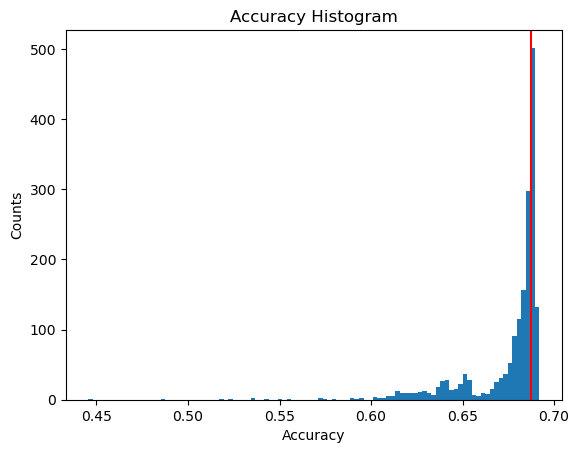

In [43]:
pre_acc = df['Pre Accuracy'].to_numpy()
post_acc = df['Post Accuracy'].to_numpy()
data = np.stack([pre_acc, post_acc], axis=1)
print(data.shape)

histogram(data=post_acc,
          n_bins=100,
          # data_range=(0.5, 0.8),
          marker=np.mean(pre_acc),
          title="Accuracy Histogram",
          xlabel="Accuracy",
          ylabel="Counts")

## Hypothesis 1: Masked modifications will have greater changes than noise

In [323]:
masked_rows = df[df['ID'].str.contains('masked')]
n_masked = len(masked_rows)

gaussian_rows = df[df['ID'].str.contains('gaussian')]
n_gaussian = len(gaussian_rows)
# Compare mean post edit accuracy, precision, recall, and f1
mean_masked = masked_rows.mean()
mean_gaussian = gaussian_rows.mean()
std_masked = masked_rows.std()
std_gaussian = gaussian_rows.std()
# print(mean_masked)

metrics = [['{} Accuracy', '{} Mean Precision', '{} Mean Recall', '{} Mean F1'], 
           ['{} Target Precision', '{} Target Recall', '{} Target F1'],
           ['{} Orig Pred Precision', '{} Orig Pred Recall', '{} Orig Pred F1']]
print("{:<30} {:<15} {:<20} {:<20}".format("Metric", "Pre-Edit", "Masked", "Gaussian"))
for row in metrics:
    for metric in row:
        print("{:<30} {:<15.3f} {:.3f}({:.3f}) {:<6} {:.3f}({:.3f})".format(
            metric.format(""), mean_masked[metric.format("Pre")],
            mean_masked[metric.format("Post")], std_masked[metric.format("Post")], "",
            mean_gaussian[metric.format("Post")], std_gaussian[metric.format("Post")]))
    print("")


Metric                         Pre-Edit        Masked               Gaussian            
 Accuracy                      0.687           0.635(0.049)        0.663(0.028)
 Mean Precision                0.692           0.660(0.052)        0.681(0.038)
 Mean Recall                   0.687           0.635(0.049)        0.663(0.028)
 Mean F1                       0.684           0.623(0.058)        0.654(0.039)

 Target Precision              0.554           0.372(0.085)        0.436(0.070)
 Target Recall                 0.549           0.713(0.079)        0.629(0.039)
 Target F1                     0.551           0.477(0.060)        0.509(0.047)

 Orig Pred Precision           0.679           0.421(0.414)        0.649(0.343)
 Orig Pred Recall              0.638           0.219(0.255)        0.385(0.263)
 Orig Pred F1                  0.648           0.265(0.295)        0.453(0.291)



### Hypothesis 2: How many edits actually improved all three metrics for target class?

Will these also incur larger harm in overall metrics?

In [358]:
improve_target_rows = df[
    (df['Post Target Precision'] > df['Pre Target Precision']) &
    (df['Post Target Recall'] > df ['Pre Target Recall']) & 
    (df['Post Target F1'] > df['Pre Target F1'])]      

improve_target_recall = df[df['Post Target Recall'] > df ['Pre Target Recall']] 
improve_target_f1 = df[df['Post Target F1'] > df ['Pre Target F1']] 
improve_target_precision = df[df['Post Target Precision'] > df ['Pre Target Precision']] 
    
improve_target_precision_f1 = pd.merge(improve_target_precision, improve_target_f1, how='inner', on=['ID'])
improve_target_recall_f1 = pd.merge(improve_target_recall, improve_target_f1, how='inner', on=['ID'])
improve_target_recall_and_precision = pd.merge(improve_target_recall, improve_target_precision, how='inner', on=['ID'])

print("{} edits improved all target metrics (P/R/F1) ".format(len(improve_target_rows)))
print("{} edits improved target recall".format(len(improve_target_recall)))
print("{} edits improved target F1".format(len(improve_target_f1)))
print("{} edits improved target precision".format(len(improve_target_precision)))
print("{} edits improved target precision + f1".format(len(improve_target_precision_f1)))
print("{} edits improved target recall + f1".format(len(improve_target_recall_f1)))
print("{} edits improved target precision + recall".format(len(improve_target_recall_and_precision)))


0 edits improved all target metrics (P/R/F1) 
127 edits improved target recall
6 edits improved target F1
0 edits improved target precision
0 edits improved target precision + f1
6 edits improved target recall + f1
0 edits improved target precision + recall


## Hypothesis 3: If the edit improved the target class (let's say F1), then the metrics of the originally predicted class will be worse

In [326]:
 orig_metrics = ['{} Orig Pred Precision', '{} Orig Pred Recall', '{} Orig Pred F1']
mean_improve_target_f1 = improve_target_f1.mean()
std_improve_target_f1 = improve_target_f1.std()

print("Average mean metrics in original predicted class for rows that improved f1 in target class ({} samples)".format(len(improve_target_f1)))
print("{:<30} {:<15} {:<20}".format("Metric", "Pre-Edit", "Post-Edit"))
for metric in orig_metrics:
    print("{:<30} {:.3f}({:.3f}) {:<6} {:.3f}({:.3f})".format(
        metric.format(""), 
        mean_improve_target_f1[metric.format("Pre")], 
        std_improve_target_f1[metric.format("Pre")], 
        "",
        mean_improve_target_f1[metric.format("Post")],
        std_improve_target_f1[metric.format("Post")]))
    
not_improve_target_f1 = df[~df.isin(improve_target_f1)].dropna()
mean_not_improve_target_f1 = not_improve_target_f1.mean()
std_not_improve_target_f1 = not_improve_target_f1.std()

print("Average mean metrics in original predicted class for rows that did NOT improve f1 in target class({} samples)".format(len(not_improve_target_f1)))
print("{:<30} {:<15} {:<20}".format("Metric", "Pre-Edit", "Post-Edit"))
for metric in orig_metrics:
    print("{:<30} {:.3f}({:.3f}) {:<6} {:.3f}({:.3f})".format(
        metric.format(""), 
        mean_not_improve_target_f1[metric.format("Pre")], 
        std_not_improve_target_f1[metric.format("Pre")], 
        "",
        mean_not_improve_target_f1[metric.format("Post")],
        std_not_improve_target_f1[metric.format("Post")]))

Average mean metrics in original predicted class for rows that improved f1 in target class (6 samples)
Metric                         Pre-Edit        Post-Edit           
 Orig Pred Precision           0.705(0.064)        0.770(0.074)
 Orig Pred Recall              0.509(0.132)        0.449(0.164)
 Orig Pred F1                  0.584(0.095)        0.550(0.122)
Average mean metrics in original predicted class for rows that did NOT improve f1 in target class(122 samples)
Metric                         Pre-Edit        Post-Edit           
 Orig Pred Precision           0.680(0.074)        0.460(0.413)
 Orig Pred Recall              0.639(0.137)        0.248(0.267)
 Orig Pred F1                  0.650(0.091)        0.298(0.306)


In [219]:
metric_name = 'Recall'
pos_target_pos_orig = df[ 
    (df['Post Target {}'.format(metric_name)] > df['Pre Target {}'.format(metric_name)]) &
    (df['Post Orig Pred {}'.format(metric_name)] > df['Pre Orig Pred {}'.format(metric_name)])]  

pos_target_neg_orig = df[ 
    (df['Post Target {}'.format(metric_name)] > df['Pre Target {}'.format(metric_name)]) &
    (df['Post Orig Pred {}'.format(metric_name)] < df['Pre Orig Pred {}'.format(metric_name)])] 

neg_target_pos_orig = df[ 
    (df['Post Target {}'.format(metric_name)] < df['Pre Target {}'.format(metric_name)]) &
    (df['Post Orig Pred {}'.format(metric_name)] > df['Pre Orig Pred {}'.format(metric_name)])]  

neg_target_neg_orig = df[ 
    (df['Post Target {}'.format(metric_name)] < df['Pre Target {}'.format(metric_name)]) &
    (df['Post Orig Pred {}'.format(metric_name)] < df['Pre Orig Pred {}'.format(metric_name)])]  


In [220]:
print("Metric: {}".format(metric_name))
print("Pos Target Pos Orig: {}".format(len(pos_target_pos_orig)))
print("Pos Target Neg Orig: {}".format(len(pos_target_neg_orig)))
print("Neg Target Pos Orig: {}".format(len(neg_target_pos_orig)))
print("Neg Target Neg Orig: {}".format(len(neg_target_neg_orig)))

Metric: Recall
Pos Target Pos Orig: 7
Pos Target Neg Orig: 120
Neg Target Pos Orig: 0
Neg Target Neg Orig: 1


## Hypothesis 4: If a gaussian noise segment is producing sucessful change, will the masked segment as well? In those cases, do the masked ones or noised ones perform better?

Result: not necessarily

In [327]:
# Count number of rows that are gaussian noise and are masked
masked_rows = df[df['ID'].str.contains('masked')]
n_masked = len(masked_rows)

gaussian_rows = df[df['ID'].str.contains('gaussian')]
n_gaussian = len(gaussian_rows)
print("{} masked modifications\n{} Gaussian modifications".format(n_masked, n_gaussian))

# For gaussian rows, are their corresponding masked segment also there?
gaussian_IDs = gaussian_rows['ID']
corresponding_masked_IDs = gaussian_IDs.replace('gaussian', 'masked', regex=True)
# print(corresponding_masked_IDs)

masked_IDs_with_both_gaussian_and_masked = list(set(corresponding_masked_IDs) & set(df['ID']))
gaussian_IDs_with_both_gaussian_and_masked = [s.replace('masked', 'gaussian') for s in masked_IDs_with_both_gaussian_and_masked]
n_both = len(masked_IDs_with_both_gaussian_and_masked)
print("{}/{} gaussian modifications have corresponding masked segment as success:".format(n_both, n_gaussian))

print("\nOf data with both masked and gaussian modifications producing changed prediction:")

masked_rows = df.loc[df['ID'].isin(masked_IDs_with_both_gaussian_and_masked)]
print("Masked results ({} rows):".format(len(masked_rows)))
print_summary(masked_rows)

gaussian_rows = df.loc[df['ID'].isin(gaussian_IDs_with_both_gaussian_and_masked)]
print("Gaussian results ({} rows):".format(len(gaussian_rows)))

print_summary(gaussian_rows)


98 masked modifications
30 Gaussian modifications
14/30 gaussian modifications have corresponding masked segment as success:

Of data with both masked and gaussian modifications producing changed prediction:
Masked results (14 rows):
Metric                         Pre-Edit        Post-Edit           
 Accuracy                      0.687           0.641(0.033)
 Mean Precision                0.692           0.670(0.046)
 Mean Recall                   0.687           0.641(0.033)
 Mean F1                       0.684           0.630(0.044)

 Target Precision              0.554           0.360(0.060)
 Target Recall                 0.549           0.734(0.052)
 Target F1                     0.551           0.478(0.043)

 Orig Pred Precision           0.661           0.402(0.423)
 Orig Pred Recall              0.567           0.220(0.265)
 Orig Pred F1                  0.601           0.268(0.305)

Gaussian results (14 rows):
Metric                         Pre-Edit        Post-Edit           

## Hypothesis 5: Smaller segments will produce smaller changes


## Hypothesis 6: The neighbors of the value images should be less affected than the neighbors of the key images

Compare distance between key-keyN and val-valN before and after the edit. The difference should be smaller for val-valN

In [332]:
# mean_diff_key_keyN = (df['Post key-keyN (F)'] - df['Pre key-keyN (F)']).mean()
mean_df = df.mean()
for data_type in ["F", "L"]:
    mean_pre_key_keyN = mean_df['Pre key-keyN ({})'.format(data_type)]
    mean_post_key_keyN = mean_df['Post key-keyN ({})'.format(data_type)]
    diff_key_keyN = mean_post_key_keyN - mean_pre_key_keyN
    percent_diff_key_keyN = diff_key_keyN / mean_pre_key_keyN * 100
    k_n_increase = len(df[df['Pre key-keyN ({})'.format(data_type)] < df['Post key-keyN ({})'.format(data_type)]])
    k_n_decrease = len(df) - k_n_increase
    # mean_diff_val_valN = (df['Post val-valN (F)'] - df['Pre val-valN (F)']).mean()
    mean_pre_val_valN = mean_df['Pre val-valN ({})'.format(data_type)]
    mean_post_val_valN = mean_df['Post val-valN ({})'.format(data_type)]
    diff_val_valN = mean_post_val_valN - mean_pre_val_valN
    percent_diff_val_valN = diff_val_valN / mean_pre_val_valN * 100
    v_n_increase = len(df[df['Pre val-valN ({})'.format(data_type)] < df['Post val-valN ({})'.format(data_type)]])
    v_n_decrease = len(df) - v_n_increase

    print("{}".format("Features" if data_type == 'F' else "Logits"))
    print("\tKey -> Key Neighbors: {:.3f} ==> {:.3f}".format(mean_pre_key_keyN, mean_post_key_keyN))
    print("\t\tMean difference: {:.3f} ({:.2f}%)".format(diff_key_keyN, percent_diff_key_keyN))
    print("\t\tNum increase: {} Num decrease: {}".format(k_n_increase, k_n_decrease))
    print("\tVal -> Val Neighbors: {:.3f} ==> {:.3f}".format(mean_pre_val_valN, mean_post_val_valN))
    print("\t\tMean difference: {:.3f} ({:.2f}%)".format(diff_val_valN, percent_diff_val_valN))
    print("\t\tNum increase: {} Num decrease: {}".format(v_n_increase, v_n_decrease))
    

Features
	Key -> Key Neighbors: 0.819 ==> 0.727
		Mean difference: -0.092 (-11.28%)
		Num increase: 6 Num decrease: 122
	Val -> Val Neighbors: 0.965 ==> 0.880
		Mean difference: -0.085 (-8.83%)
		Num increase: 5 Num decrease: 123
Logits
	Key -> Key Neighbors: 1.106 ==> 0.903
		Mean difference: -0.203 (-18.38%)
		Num increase: 12 Num decrease: 116
	Val -> Val Neighbors: 1.308 ==> 1.086
		Mean difference: -0.223 (-17.02%)
		Num increase: 3 Num decrease: 125


## Hypothesis 7: Edits that shared an original image will have smaller spread in post edit metrics


In [333]:
# Obtain unique key images

unique_keys = get_unique_key_images(df)
print("{} unique key images".format(len(unique_keys)))

metrics = [['{} Accuracy', '{} Mean Precision', '{} Mean Recall', '{} Mean F1'], 
           ['{} Target Precision', '{} Target Recall', '{} Target F1'],
           ['{} Orig Pred Precision', '{} Orig Pred Recall', '{} Orig Pred F1'],
           # ['{} key-val (F)'],
          ]


key_image_stds = pd.DataFrame()
small_spread_keys = []
for unique_key in unique_keys:
    cur_rows = df[df['ID'].str.contains(unique_key)]
    mean_cur_rows = cur_rows.mean()
    std_cur_rows = cur_rows.std()
    # print("Accuracy STD: {:.3f}".format(std_cur_rows['Post Accuracy']))
    # print("Precision STD: {:.3f}".format(std_cur_rows['Post Mean Precision']))
    # print("Recall STD: {:.3f}".format(std_cur_rows['Post Mean Recall']))
    if std_cur_rows['Post Accuracy'] < 0.04:
        small_spread_keys.append(unique_key)
    # else:
    #     print(cur_rows['Post Accuracy'])
    if len(cur_rows) > 1:
        key_image_stds = key_image_stds.append(std_cur_rows, ignore_index=True)
        

mean_key_image_stds = key_image_stds.mean()
print("{:<30} {:<15} {:<20}".format("Metric", "STD Overall", "Avg STD Grouped by Key Image"))
for row in metrics:
    for metric in row:
        print("{:<30} {:<15.3f} {:.3f} ({:.2f}%)".format(
            metric.format("Post"), std_df[metric.format("Post")],
            mean_key_image_stds[metric.format("Post")],
            100 * mean_key_image_stds[metric.format("Post")] / std_df[metric.format("Post")]))
    print("")

# print("Average accuracy standard deviation for an image: {}".format(key_image_stds['Post Accuracy']))
# print(small_spread_keys)

20 unique key images
Metric                         STD Overall     Avg STD Grouped by Key Image
Post Accuracy                  0.046           0.034 (72.70%)
Post Mean Precision            0.050           0.041 (82.69%)
Post Mean Recall               0.046           0.034 (72.70%)
Post Mean F1                   0.055           0.042 (75.31%)

Post Target Precision          0.086           0.069 (79.79%)
Post Target Recall             0.080           0.057 (71.72%)
Post Target F1                 0.058           0.046 (78.07%)

Post Orig Pred Precision       0.409           0.397 (97.24%)
Post Orig Pred Recall          0.266           0.213 (80.19%)
Post Orig Pred F1              0.304           0.253 (83.20%)



## Hypothesis 8: When grouping by same key image, is there a trend to variation in post edit distances?

In [341]:
unique_keys = get_unique_key_images(df)

metrics = [['{} key-val (F)'], 
           ['{} key-valN (F)', '{} val-keyN (F)', '{} key-keyN (F)', '{} val-valN (F)']
           ]
print("Overall distance summaries")
print_summary(df, metrics=metrics)
keys_small_dist_stds = []
small_std_rows = pd.DataFrame()
random_std_rows = pd.DataFrame()
for unique_key in unique_keys:
    # print("Distance summaries for {}".format(unique_key))
    cur_rows = df[df['ID'].str.contains(unique_key)]
    mean_cur_rows = cur_rows.mean()
    std_cur_rows = cur_rows.std()
    # print_summary(cur_rows, metrics=metrics)
    # Store this key if all its stds are < overall
    do_store = True
    for metric_row in metrics:
        for metric in metric_row:
            metric = metric.format("Post")
            if std_df[metric] < std_cur_rows[metric]:
                do_store = False
        
    if do_store:
        keys_small_dist_stds.append(unique_key)
        small_std_rows = small_std_rows.append(std_cur_rows, ignore_index=True)
        
    # Random subsets
    random_idxs = np.random.randint(len(df), size=len(cur_rows))
    random_rows = df.iloc[random_idxs]
    random_std_rows = random_std_rows.append(random_rows.std(), ignore_index=True)
    
        
mean_small_std_rows = small_std_rows.mean()
# mean_random_std_rows = random_std_rows.mean()
print("{:<30} {:<15} {:<20} {:<20}".format("Metric", "STD Overall", "Avg STD by Key", "Random subsets"))
for row in metrics:
    for metric in row:
        print("{:<30} {:<15.3f} {:.3f} ({:.2f}%)\t    {:<15.3f}".format(
            metric.format("Post"), std_df[metric.format("Post")],
            mean_small_std_rows[metric.format("Post")],
            100 * mean_small_std_rows[metric.format("Post")] / std_df[metric.format("Post")],
            mean_random_std_rows[metric.format("Post")]))
    print("")

Overall distance summaries
Metric                         Pre-Edit        Post-Edit           
 key-val (F)                   3.649           2.044(0.579)

 key-valN (F)                  3.820           2.252(0.451)
 val-keyN (F)                  3.794           2.216(0.481)
 key-keyN (F)                  0.819           0.727(0.334)
 val-valN (F)                  0.965           0.880(0.237)

Metric                         STD Overall     Avg STD by Key       Random subsets      
Post key-val (F)               0.579           0.284 (49.02%)	    0.507          

Post key-valN (F)              0.451           0.233 (51.58%)	    0.402          
Post val-keyN (F)              0.481           0.249 (51.91%)	    0.426          
Post key-keyN (F)              0.334           0.038 (11.52%)	    0.284          
Post val-valN (F)              0.237           0.137 (57.71%)	    0.181          



## Hypothesis 9: Edits that share a original prediction will have more similar post edit metric results

In [343]:
metrics = [['{} Accuracy', '{} Mean Precision', '{} Mean Recall', '{} Mean F1'], 
           ['{} Target Precision', '{} Target Recall', '{} Target F1'],
           ['{} Orig Pred Precision', '{} Orig Pred Recall', '{} Orig Pred F1'],
           # ['{} key-val (F)'],
          ]

unique_original_predictions = set(df['Pre key Prediction'])

unique_originals_stds = pd.DataFrame()
for og_prediction in unique_original_predictions:
    cur_rows = df[df['Pre key Prediction'] == og_prediction]
    if len(cur_rows) > 1:
        unique_originals_stds = unique_originals_stds.append(std_cur_rows, ignore_index=True)
    # print(len(cur_rows))
    mean_cur_rows = cur_rows.mean()
    std_cur_rows = cur_rows.std()
#     print("Original prediction: {}".format(og_prediction))
#     print("N samples: {}".format(len(cur_rows)))
#     print_summary(cur_rows)
    
mean_unique_originals_stds = unique_originals_stds.mean()
print("{:<30} {:<15} {:<20}".format("Metric", "STD Overall", "Avg STD by Orig. Pred."))
for row in metrics:
    for metric in row:
        print("{:<30} {:<15.3f} {:.3f} ({:.2f}%)".format(
            metric.format("Post"), std_df[metric.format("Post")],
            mean_unique_originals_stds[metric.format("Post")],
            100 * mean_unique_originals_stds[metric.format("Post")] / std_df[metric.format("Post")]))
    print("")

Metric                         STD Overall     Avg STD by Orig. Pred.
Post Accuracy                  0.046           0.045 (96.71%)
Post Mean Precision            0.050           0.043 (85.77%)
Post Mean Recall               0.046           0.045 (96.71%)
Post Mean F1                   0.055           0.053 (96.10%)

Post Target Precision          0.086           0.083 (96.47%)
Post Target Recall             0.080           0.073 (91.21%)
Post Target F1                 0.058           0.057 (98.14%)

Post Orig Pred Precision       0.409           0.348 (85.20%)
Post Orig Pred Recall          0.266           0.226 (85.02%)
Post Orig Pred F1              0.304           0.263 (86.43%)



## Hypothesis 10: did any edits cause post edit distances to increase?

In [348]:
metrics = [
    ['{} key-val (F)', '{} val-keyN (F)', '{} key-valN (F)', '{} key-keyN (F)', '{} val-valN (F)']
]
# Obtain for non exclusionary (may include rows where other distances increase too
for metric in metrics[0]:
    print("Metric:{}".format(metric.format("")))
    kv_f = df[df[metric.format('Post')] > df[metric.format('Pre')]]

        
    print("{} edits caused distance to increase (among others)".format(len(kv_f)))
    print_summary(kv_f)
    
    # Ensure all other metrics decrease after edit
    exc_kv_f = kv_f.copy()
    for other in metrics[0]:
        if other == metric:
            continue
        exc_kv_f = exc_kv_f[exc_kv_f[other.format("Post")] < exc_kv_f[other.format("Pre")]]
    print("{} edits caused solely {} distance to increase ".format(len(exc_kv_f), metric.format("")))
    print_summary(exc_kv_f)
    # print_summaries(
    #     df_list=[kv_f, exc_kv_f],
    #     headers=["Inclusive ({})".format(len(kv_f)), "Exclusive ({})".format(len(exc_kv_f))])
                             

Metric: key-val (F)
1 edits caused distance to increase (among others)
Metric                         Pre-Edit        Post-Edit           
 Accuracy                      0.687           0.654(nan)
 Mean Precision                0.692           0.731(nan)
 Mean Recall                   0.687           0.655(nan)
 Mean F1                       0.684           0.665(nan)

 Target Precision              0.554           0.325(nan)
 Target Recall                 0.549           0.809(nan)
 Target F1                     0.551           0.464(nan)

 Orig Pred Precision           0.722           0.732(nan)
 Orig Pred Recall              0.668           0.696(nan)
 Orig Pred F1                  0.694           0.714(nan)

0 edits caused solely  key-val (F) distance to increase 
Metric                         Pre-Edit        Post-Edit           
 Accuracy                      nan             nan(nan)
 Mean Precision                nan             nan(nan)
 Mean Recall                   nan       

## Hypothesis 11: How do the edits that improve recall of both target and original class differ from those that only improve target class (and decrease original class recall)?

In [354]:
metric_name = 'F1'
pos_target_pos_orig = df[ 
    (df['Post Target {}'.format(metric_name)] > df['Pre Target {}'.format(metric_name)]) &
    (df['Post Orig Pred {}'.format(metric_name)] > df['Pre Orig Pred {}'.format(metric_name)])]  

pos_target_neg_orig = df[ 
    (df['Post Target {}'.format(metric_name)] > df['Pre Target {}'.format(metric_name)]) &
    (df['Post Orig Pred {}'.format(metric_name)] < df['Pre Orig Pred {}'.format(metric_name)])] 



In [355]:
print("Increase target and orig. prediction")
print_summary(pos_target_pos_orig)

    
# get_unique(pos_target_pos_orig)

print("Increase target and decrease orig. prediction")
print_summary(pos_target_neg_orig)
# get_unique(pos_target_neg_orig)

# Print how many neighbors became target
keys = [
    "Num of key's Neighbors Became Target (F)", 
    # "Num of key's Neighbors Unaffected (F)", 
    "Num of key's Neighbors Became Target (L)",
    # "Num of key's Neighbors Unaffected (L)", 
    "Num of val's Neighbors Became Target (F)", 
    # "Num of val's Neighbors Unaffected (F)", 
    "Num of val's Neighbors Became Target (L)",
    # "Num of val's Neighbors Unaffected (L)", 
]
key_abbr = [
    "Key features", "Key logits", "Val features", "Val logits"
]
print("Pos Target Pos Orig ({}):".format(len(pos_target_pos_orig)))
for key, abbr in zip(keys, key_abbr):
    pp_key = pos_target_pos_orig[key]
    # print("Key: {}".format(key))
    print("{} \tmean: {:.3f} median: {}".format(abbr, pp_key.mean(), pp_key.median()))
    # print(pp_key)
    
print("Pos Target Neg Orig ({}):".format(len(pos_target_neg_orig)))
for key, abbr in zip(keys, key_abbr):
    pn_key = pos_target_neg_orig[key]
    print("{} \tmean: {:.3f} median: {}".format(abbr, pn_key.mean(), pn_key.median()))
    # print(pn_key)

Increase target and orig. prediction
Metric                         Pre-Edit        Post-Edit           
 Accuracy                      0.687           0.687(nan)
 Mean Precision                0.692           0.694(nan)
 Mean Recall                   0.687           0.687(nan)
 Mean F1                       0.684           0.684(nan)

 Target Precision              0.554           0.530(nan)
 Target Recall                 0.549           0.574(nan)
 Target F1                     0.551           0.551(nan)

 Orig Pred Precision           0.804           0.810(nan)
 Orig Pred Recall              0.734           0.729(nan)
 Orig Pred F1                  0.767           0.768(nan)

Increase target and decrease orig. prediction
Metric                         Pre-Edit        Post-Edit           
 Accuracy                      0.687           0.677(0.016)
 Mean Precision                0.692           0.699(0.006)
 Mean Recall                   0.687           0.677(0.016)
 Mean F1          

## Hypothesis 12: Given the changes in neighbor predictions, will we be able to see patterns in performance? 

In [262]:
thirds = [(0, 33), (34,66), (67, 100)]
quarters = [(0, 25), (26, 50), (51, 75), (76, 100)]
for (low, high) in thirds:
    cur_third = df[((df["Num of key's Neighbors Became Target (F)"] >= low) &
                    (df["Num of key's Neighbors Became Target (F)"] <= high))]

    print("{} edits with {}-{} of key's neighbors becoming target".format(len(cur_third), low, high))
    print_summary(cur_third)
    
for (low, high) in quarters:
    cur_third = df[((df["Num of val's Neighbors Became Target (F)"] >= low) &
                    (df["Num of val's Neighbors Became Target (F)"] <= high))]

    print("{} edits with {}-{} of val's neighbors becoming target".format(len(cur_third), low, high))
    print_summary(cur_third)


9 edits with 0-33 of key's neighbors becoming target
Metric                         Pre-Edit        Post-Edit           
 Accuracy                      0.687           0.681(0.005)
 Mean Precision                0.692           0.698(0.004)
 Mean Recall                   0.687           0.681(0.005)
 Mean F1                       0.684           0.677(0.007)

 Target Precision              0.554           0.495(0.039)
 Target Recall                 0.549           0.601(0.038)
 Target F1                     0.551           0.541(0.012)

 Orig Pred Precision           0.694           0.783(0.061)
 Orig Pred Recall              0.583           0.499(0.179)
 Orig Pred F1                  0.627           0.590(0.136)

26 edits with 34-66 of key's neighbors becoming target
Metric                         Pre-Edit        Post-Edit           
 Accuracy                      0.687           0.673(0.019)
 Mean Precision                0.692           0.691(0.027)
 Mean Recall                   0.

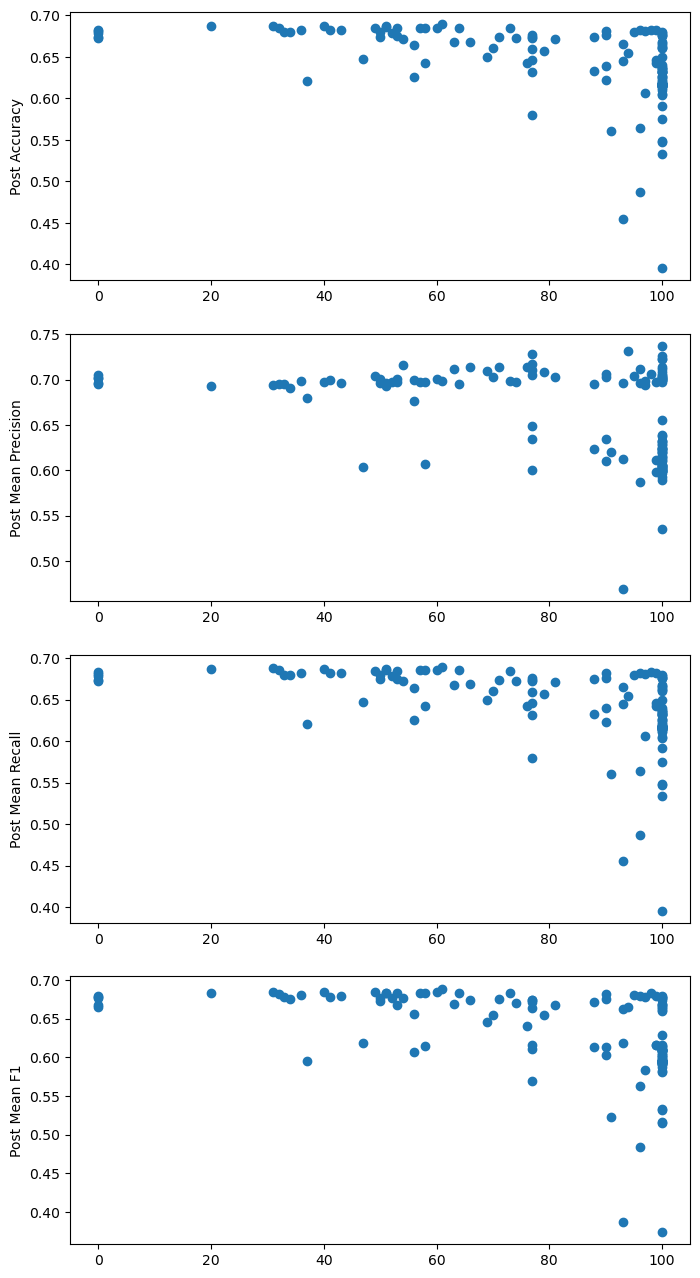

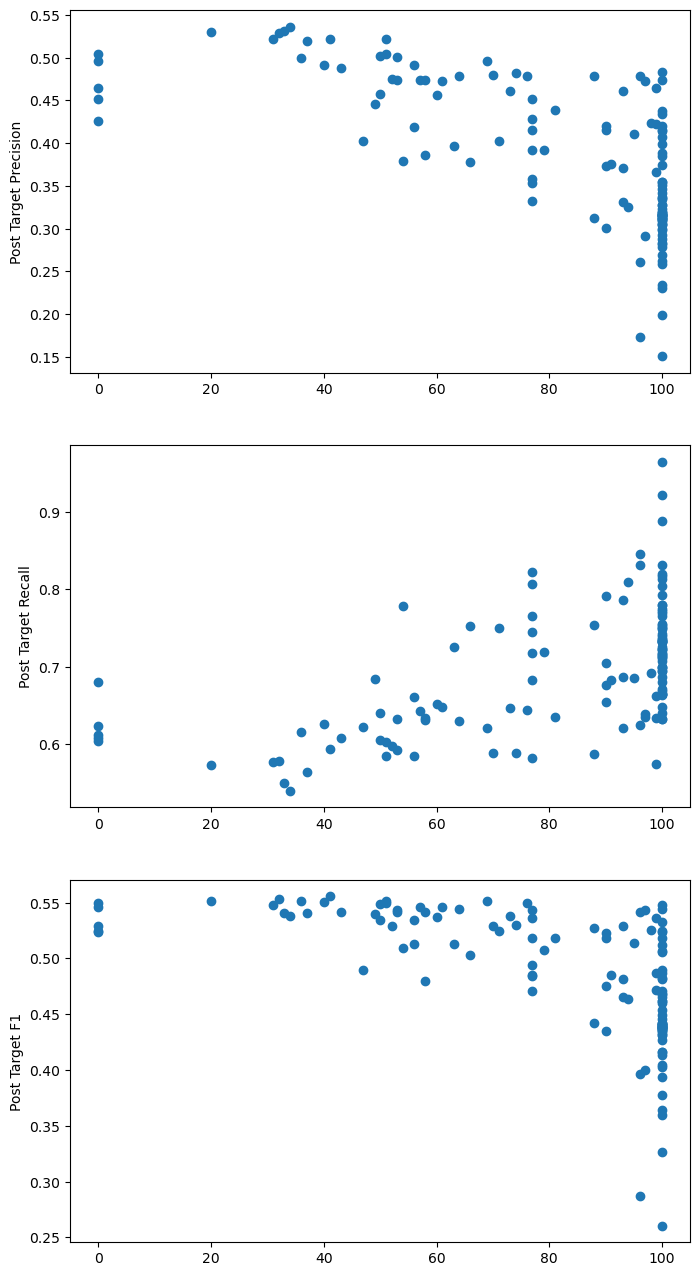

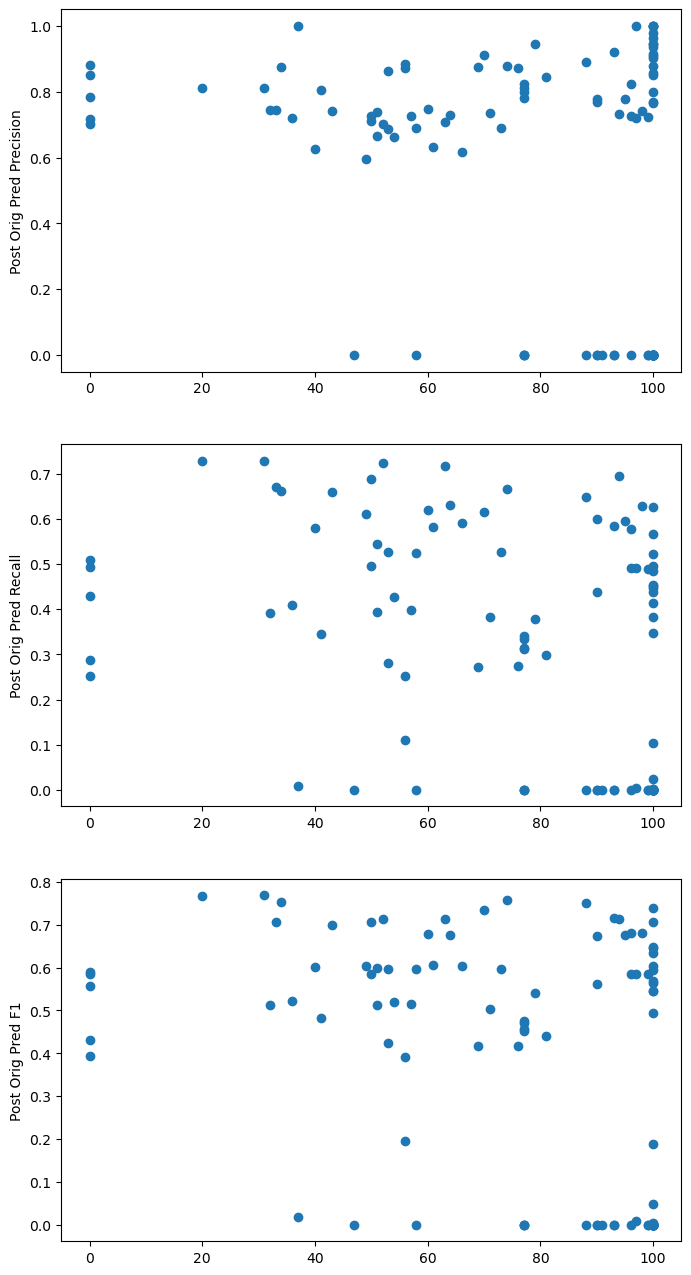

In [357]:
x_axis = df["Num of key's Neighbors Became Target (F)"].to_numpy()
metrics = [['{} Accuracy', '{} Mean Precision', '{} Mean Recall', '{} Mean F1'], 
           ['{} Target Precision', '{} Target Recall', '{} Target F1'],
           ['{} Orig Pred Precision', '{} Orig Pred Recall', '{} Orig Pred F1'],
           # ['{} key-val (F)'],
          ]
# metric = "Post Mean Recall"
# metric = "Post Orig Pred Recall"

for row_idx, row in enumerate(metrics):
    fig, axs = plt.subplots(len(row), figsize=(8, 16))
    for idx, metric in enumerate(row):
        ax = axs[idx]
        metric = metric.format("Post")
        y_axis = df[metric].to_numpy()
        ax.scatter(x_axis, y_axis)
        ax.set_ylabel(metric)

    plt.savefig('temp/{}.png'.format(row_idx))
    plt.show()